# SIR Model

The ideia is to create an SIR model to use as a baseline, to see how it compares to real world data and, afterwards, how the more complex models behave in contrast to this one.

In [54]:
from collections import namedtuple
from scipy.integrate import odeint
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [213]:
# https://web.stanford.edu/~jhj1/teachingdocs/Jones-on-R0.pdf

#We can use the fact that R0 is a dimensionless number to help us in calculating it.
# R0 = τ · c¯ · d (1)
# where τ is the transmissibility (i.e., probability of infection given contact between a susceptible and infected individual), 
# c is the average rate of contact between susceptible and infected
# individuals, and d is the duration of infectiousness.


#https://www.ncbi.nlm.nih.gov/pubmed/32097725
# The Maximum-Likelihood (ML) value of R0 was 2.28 for COVID-19 outbreak at the early stage on the ship. 
# The median with 95% confidence interval (CI) of R0 values was 2.28 (2.06-2.52) estimated by the bootstrap 
# resampling method.
R_0 = 2.28 

#In our closed population of N individuals, say that S are susceptible, I infected, and R are
#removed. Write s = S/N, i = I/N, r = R/N to denote the fraction in each compartment.

N = 8e6

i = 100 / N

s = (N-I) / N

r = 0 / N

# β = τc and is known as the effective contact rate

B = 3.2

v = 0.23

def SIR_derivatives(values, t):
    s = values[0]
    i = values[1]
    r = values[2]
    
    dsdt = -B * s * i
    
    didt = B * s * i - v * i
    
    drdt = v * i
    
    return [dsdt, didt, drdt]




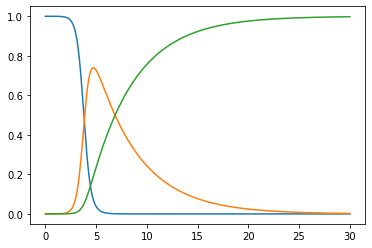

In [214]:

t = np.linspace(0, 30, 1000)
x0 = [s, i, r]
x = odeint(SIR_derivatives, x0, t)

plt.plot(t, x[:,0])
plt.plot(t, x[:,1])
plt.plot(t, x[:,2])

In [215]:
# data from https://github.com/owid/covid-19-data/tree/master/public/data
# df = pd.read_csv('..\\..\\data\\raw\\owid-covid-data.csv')

In [259]:
# data from https://data.humdata.org/dataset/novel-coronavirus-2019-ncov-cases

confirmed = pd.read_csv('..\\..\\data\\raw\\humdata\\time_series_covid19_confirmed_global.csv')
deaths = pd.read_csv('..\\..\\data\\raw\\humdata\\time_series_covid19_deaths_global.csv')
recovered = pd.read_csv('..\\..\\data\\raw\\humdata\\time_series_covid19_recovered_global.csv')

In [260]:
# We are going to use sweden and Denmark as benchmarks for countrys with similar populations 

sweden_pop = 10e6
denmark_pop = 5.8e6

In [297]:
df = confirmed[confirmed['Country/Region'] == 'Sweden']
df = df.drop(columns = ['Province/State', 'Country/Region', 'Lat', 'Long']).T
df.columns = ['confirmed']

tmp = deaths[deaths['Country/Region'] == 'Sweden']
tmp = tmp.drop(columns = ['Province/State', 'Country/Region', 'Lat', 'Long']).T
tmp.columns = ['dead']

df['dead'] = tmp['dead']

tmp = recovered[recovered['Country/Region'] == 'Sweden']
tmp = tmp.drop(columns = ['Province/State', 'Country/Region', 'Lat', 'Long']).T
tmp.columns = ['recovered']

df['recovered'] = tmp['recovered']


df = df[df['confirmed'] >= 100]

In [308]:
df.index = df.index.to_series().apply(pd.to_datetime)
start_date = df.index.min()
df.index = df.index.to_series().apply(lambda x: (x - start_date).days)

In [311]:
df['i'] = (df['confirmed'] - df['dead'] - df['recovered']) / sweden_pop
df['s'] = (sweden_pop - df['confirmed'] - df['recovered'] - df['dead']) / sweden_pop
df['r'] = (df['dead'] + df['recovered']) / sweden_pop

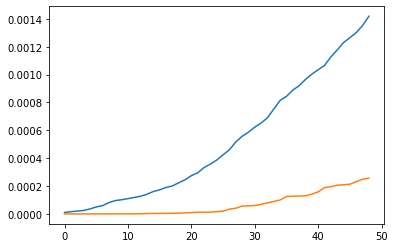

In [312]:
plt.plot(df.index , df['i'])
#plt.plot(df.index, df['s'])
plt.plot(df.index, df['r'])

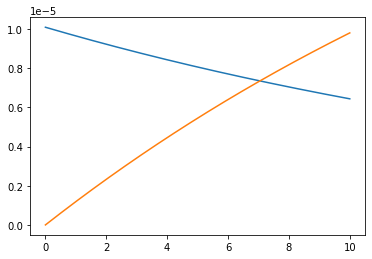

In [326]:
B = df['i'].pct_change().replace(np.inf, np.nan).dropna().median()
v = df['r'].pct_change().replace(np.inf, np.nan).dropna().median()


t = np.linspace(0, 10, 1000)
x0 = [df.iloc[0]['s'], df.iloc[0]['i'], df.iloc[0]['r']]
x = odeint(SIR_derivatives, x0, t)

#plt.plot(t, x[:,0])
plt.plot(t, x[:,1])
plt.plot(t, x[:,2])

In [327]:
B/v

0.6272402449744049